In [ ]:
!pip install pandas numpy scikit-learn xgboost lightgbm matplotlib


In [ ]:

import pandas as pd
import datetime
from random import randint
from time import sleep
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

DATA_NFL_DIR = "/content/drive/MyDrive/NFL_Project/reports"
os.makedirs(DATA_NFL_DIR, exist_ok=True)

df = pd.read_csv(f"{DATA_NFL_DIR}/games_clean_2019_2025_international_HFA_MOV.csv")
print("Loaded data:", df.shape)
df.head(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loaded data: (1869, 27)


,season,season_type,Week,week_num,Date,home_team,away_team,home_score,away_score,Winner/tie,...,elo_hfa_pts_season,elo_hfa_pts_team_filled,elo_hfa_pts_season_filled,home_field_advantage_pts,pre_elo_home,pre_elo_away,expected_home_win_prob,margin_of_victory,mov_multiplier,home_win
0,2019,regular,1,1.0,2019-09-05,Chicago Bears,Green Bay Packers,3.0,10.0,Green Bay Packers,...,12.267528,-31.672498,12.267528,-10.000000,1500.0,1500.0,0.485613,7.0,2.079442,0.0
1,2019,regular,1,1.0,2019-09-08,Minnesota Vikings,Atlanta Falcons,28.0,12.0,Minnesota Vikings,...,12.267528,70.436504,12.267528,67.282705,1500.0,1500.0,0.595635,16.0,2.833213,1.0
2,2019,regular,1,1.0,2019-09-08,New York Jets,Buffalo Bills,16.0,17.0,Buffalo Bills,...,12.267528,-93.633282,12.267528,-10.000000,1500.0,1500.0,0.485613,1.0,0.693147,0.0


Output files (to be generated):

- games_elo_noncontinuous.csv – Elo ratings reset each season

- games_elo_continuous.csv – Elo ratings carried across season

purpose:

 Implement the Elo rating system using dynamic team ratings and per-game Home Field Advantage (HFA). Both non-continuous (reset each season) and continuous (carry over to next season) variants will be produced. Each game’s expected win probability is computed from current Elo ratings plus the game’s HFA, and rating updates are scaled by a margin-of-victory (MOV) multiplier.

columns:
- season
- week_num
- home_team
- away_team
- home_score
- away_score
- home_win (1, 0, or 0.5)
- home_field_advantage_pts (per-game HFA in Elo points; 0 for international/neutral games)
- is_international (used only to validate HFA=0 on these rows)
- mov_multiplier (log(MOV+1) tempered term; currently ln(MOV+1) when ratings are equal)
- expected_home_win_prob (baseline from data pipeline; used for QA/ML features, not for Elo math)

# ELO Model

In [ ]:
In_PATH = f"{DATA_NFL_DIR}/games_clean_2019_2025_international_HFA_MOV.csv"

#Paramaters
K_FACTOR = 20.0
INTITIAL_ELO  = 1500.0
ELO_SCALE =  400.0
EPS = 1e-12

In [ ]:
#Helper Functions

#Expected win probability using ELO and HFA
def expected_home_win(r_home, r_away, hfa):
  diff = (r_home + hfa) - r_away

  return 1.0/(1.0+10 **(-(diff/ELO_SCALE)))

#Update ELO rating
def Update_ratings(r_home, r_away, s_home, e_home, mov_mult, k):
  delta = k * (s_home - e_home) * mov_mult
  return r_home + delta, r_away - delta, delta

In [ ]:
OUT_PATH = f"{DATA_NFL_DIR}/games_elo_noncontinuous.csv"

#load and basic check
df = pd.read_csv(In_PATH)

required = [
  "season", "week_num", "home_team", "away_team",
  "home_score", "away_score", "home_win",
  "home_field_advantage_pts", "mov_multiplier"
]

missing  = [c for c in required if c not in df.columns]
if missing:
  raise ValueError(f"Missing required columns: {missing}")

#sort by season and week
#df.sort_values(["season","week_num"]).reset_index(drop=True)
df = df.sort_values(["season", "week_num", "Date", "home_team", "away_team"])

#ELo loop-non-continous.
ratings = {}
current_season = None
rows= []

for idx, g in df.iterrows():
  season = int(g["season"])
  if (current_season is None) or (current_season != season):
    ratings = {} #resent rating
    current_season = season

  home = g["home_team"]
  away = g["away_team"]

  #get the initial ratings
  r_home = ratings.get(home, INTITIAL_ELO)
  r_away = ratings.get(away, INTITIAL_ELO)

  #compute the expected with prob(uses per-game HFA)
  hfa = g["home_field_advantage_pts"]
  e_home = expected_home_win(r_home, r_away, hfa)

  #actual results [1,0, or 0.5]
  s_home = g["home_win"]
  mov_mult = g["mov_multiplier"]

  #Apply Elo update
  post_home, post_away, delta = Update_ratings(r_home, r_away, s_home, e_home, mov_mult, K_FACTOR)

  #save to the dictionary
  ratings[home] = post_home
  ratings[away] = post_away

  #Record row
  row = dict(g)
  row.update({
      "pre_elo_home": r_home,
      "pre_elo_away": r_away,
      "elo_E_home": e_home,
      "elo_delta_home": post_home,
      "post_elo_home": post_home,
      "post_elo_away": post_away,
  })
  rows.append(row)

#combine results
elo_noncont = pd.DataFrame(rows)

#save output
elo_noncont.to_csv(OUT_PATH, index=False)
print(f"Saved to {OUT_PATH}")
print(elo_noncont.head(15)[[
    "season", "week_num", "home_team", "away_team",
    "home_field_advantage_pts", "pre_elo_home", "pre_elo_away",
    "elo_E_home", "elo_delta_home", "post_elo_home", "post_elo_away"
]])





Saved to /content/drive/MyDrive/NFL_Project/reports/games_elo_noncontinuous.csv
    season  week_num             home_team              away_team  \
0     2019       1.0         Chicago Bears      Green Bay Packers   
1     2019       1.0     Arizona Cardinals          Detroit Lions   
2     2019       1.0     Carolina Panthers       Los Angeles Rams   
3     2019       1.0      Cleveland Browns       Tennessee Titans   
4     2019       1.0        Dallas Cowboys        New York Giants   
5     2019       1.0  Jacksonville Jaguars     Kansas City Chiefs   
6     2019       1.0  Los Angeles Chargers     Indianapolis Colts   
7     2019       1.0        Miami Dolphins       Baltimore Ravens   
8     2019       1.0     Minnesota Vikings        Atlanta Falcons   
9     2019       1.0  New England Patriots    Pittsburgh Steelers   
10    2019       1.0         New York Jets          Buffalo Bills   
11    2019       1.0   Philadelphia Eagles  Washington Commanders   
12    2019       1.0   

Wanted to check validate my data by looking over the data which maches and checking for empty values. values found that are missing are the away games "Unnamed: 5" and the non season games in "week_num". This checks out.  

In [ ]:
missing = elo_noncont.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)

missing_df = pd.DataFrame({'Missing Values': missing, "missing_percentage":(missing/len(elo_noncont) * 100).round(2)})
print("Missing values: ")
display(missing_df)

#inspect rows missing week_num
elo_noncont[elo_noncont["week_num"].isna()].head(10)
elo_noncont[elo_noncont["Unnamed: 5"].isna()].head(10)



Missing values: 


,Missing Values,missing_percentage
Unnamed: 5,1002,53.61
week_num,76,4.07


,season,season_type,Week,week_num,Date,home_team,away_team,home_score,away_score,Winner/tie,...,pre_elo_home,pre_elo_away,expected_home_win_prob,margin_of_victory,mov_multiplier,home_win,elo_E_home,elo_delta_home,post_elo_home,post_elo_away
4,2019,regular,1,1.0,2019-09-08,Dallas Cowboys,New York Giants,35.0,17.0,Dallas Cowboys,...,1500.000000,1500.000000,0.626699,18.0,2.944439,1.0,0.626699,1521.983235,1521.983235,1478.016765
6,2019,regular,1,1.0,2019-09-08,Los Angeles Chargers,Indianapolis Colts,30.0,24.0,Los Angeles Chargers,...,1500.000000,1500.000000,0.486692,6.0,1.945910,1.0,0.486692,1519.977039,1519.977039,1480.022961
8,2019,regular,1,1.0,2019-09-08,Minnesota Vikings,Atlanta Falcons,28.0,12.0,Minnesota Vikings,...,1500.000000,1500.000000,0.595635,16.0,2.833213,1.0,0.595635,1522.913043,1522.913043,1477.086957
9,2019,regular,1,1.0,2019-09-08,New England Patriots,Pittsburgh Steelers,33.0,3.0,New England Patriots,...,1500.000000,1500.000000,0.485613,30.0,3.433987,1.0,0.485613,1535.327980,1535.327980,1464.672020
11,2019,regular,1,1.0,2019-09-08,Philadelphia Eagles,Washington Commanders,32.0,27.0,Philadelphia Eagles,...,1500.000000,1500.000000,0.626699,5.0,1.791759,1.0,0.626699,1513.377309,1513.377309,1486.622691
12,2019,regular,1,1.0,2019-09-08,Seattle Seahawks,Cincinnati Bengals,21.0,20.0,Seattle Seahawks,...,1500.000000,1500.000000,0.549081,1.0,0.693147,1.0,0.549081,1506.251070,1506.251070,1493.748930
14,2019,regular,1,1.0,2019-09-09,Las Vegas Raiders,Denver Broncos,24.0,16.0,Oakland Raiders,...,1500.000000,1500.000000,0.485613,8.0,2.197225,1.0,0.485613,1522.604483,1522.604483,1477.395517
15,2019,regular,1,1.0,2019-09-09,New Orleans Saints,Houston Texans,30.0,28.0,New Orleans Saints,...,1500.000000,1500.000000,0.495461,2.0,1.098612,1.0,0.495461,1511.085845,1511.085845,1488.914155
17,2019,regular,2,2.0,2019-09-15,Atlanta Falcons,Philadelphia Eagles,24.0,20.0,Atlanta Falcons,...,1477.086957,1513.377309,0.485613,4.0,1.609438,1.0,0.433774,1495.313062,1495.313062,1495.151205
18,2019,regular,2,2.0,2019-09-15,Baltimore Ravens,Arizona Cardinals,23.0,17.0,Baltimore Ravens,...,1549.033224,1500.000000,0.626699,6.0,1.945910,1.0,0.690047,1561.096034,1561.096034,1487.937191


In [ ]:
elo_noncont[elo_noncont["week_num"].isna()][
    ["season", "Week", "week_num", "home_team", "away_team"]
].head(10)


,season,Week,week_num,home_team,away_team
256,2019,WildCard,NaN,Houston Texans,Buffalo Bills
257,2019,WildCard,NaN,New England Patriots,Tennessee Titans
258,2019,WildCard,NaN,New Orleans Saints,Minnesota Vikings
259,2019,WildCard,NaN,Philadelphia Eagles,Seattle Seahawks
260,2019,Division,NaN,Baltimore Ravens,Tennessee Titans
261,2019,Division,NaN,San Francisco 49ers,Minnesota Vikings
262,2019,Division,NaN,Green Bay Packers,Seattle Seahawks
263,2019,Division,NaN,Kansas City Chiefs,Houston Texans
264,2019,ConfChamp,NaN,Kansas City Chiefs,Tennessee Titans
265,2019,ConfChamp,NaN,San Francisco 49ers,Green Bay Packers


# Visual

In [ ]:
elo_nc = pd.read_csv(f"{DATA_NFL_DIR}/games_elo_noncontinuous.csv")
teams_meta = pd.read_csv(f"{DATA_NFL_DIR}/nfl_teams_conferences.csv")

#Create a lookup dictionary: teams -> suffix (e.g. "NFC-N")
teams_meta["suffix"] = teams_meta["conference"] + "-" + teams_meta["division"].str[0]
lookup = dict(zip(teams_meta["team"], teams_meta["suffix"]))

#Apply suffix to both home and away
elo_nc["home_team_full"] = elo_nc["home_team"].map(lookup).fillna("")
elo_nc["away_team_full"] = elo_nc["away_team"].map(lookup).fillna("")

elo_nc ["home_team_label"] = elo_nc["home_team"] + "-" + elo_nc["home_team_full"]
elo_nc ["away_team_label"] = elo_nc["away_team"] + "-" + elo_nc["away_team_full"]

elo_nc[["home_team_label", "away_team_label"]].head()


,home_team_label,away_team_label
0,Chicago Bears-NFC-N,Green Bay Packers-NFC-N
1,Arizona Cardinals-NFC-W,Detroit Lions-NFC-N
2,Carolina Panthers-NFC-S,Los Angeles Rams-NFC-W
3,Cleveland Browns-AFC-N,Tennessee Titans-AFC-S
4,Dallas Cowboys-NFC-E,New York Giants-NFC-E


Team Elo progression within a season

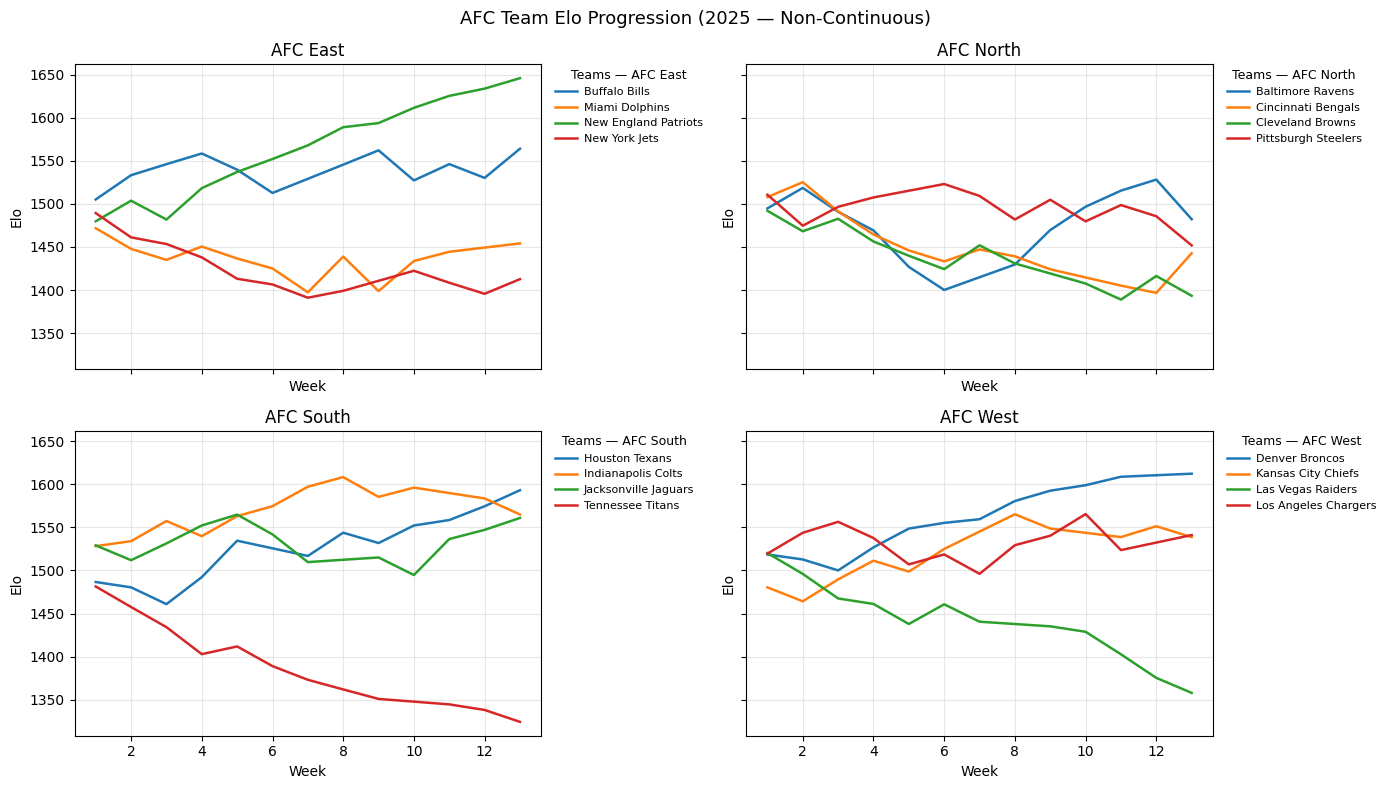

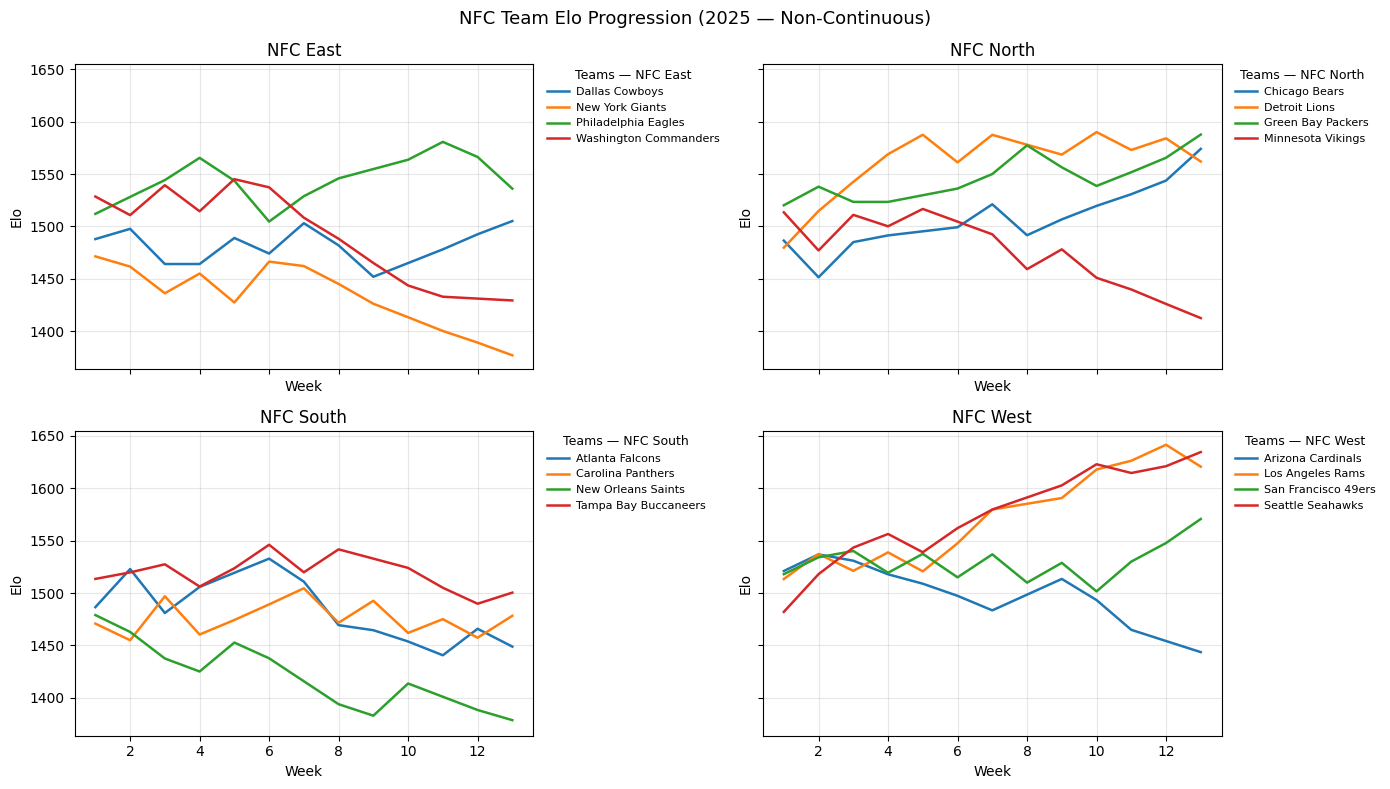

In [ ]:
# ---- Inputs ----
season_year = 2025
PATH = f"{DATA_NFL_DIR}/games_elo_noncontinuous.csv"

df = elo_nc

# Build a unified team-week Elo series (combine home+away)
home = df[["season","week_num","Date","home_team_label","post_elo_home"]].rename(
    columns={"home_team_label":"team_label","post_elo_home":"elo"})
away = df[["season","week_num","Date","away_team_label","post_elo_away"]].rename(
    columns={"away_team_label":"team_label","post_elo_away":"elo"})
long = pd.concat([home, away], ignore_index=True)

# Filter to the season of interest and drop rows without week_num/elo
long = long[(long["season"] == season_year) & long["week_num"].notna() & long["elo"].notna()].copy()

# Extract conference (middle token) and division initial (last token) from the label "Team-Conf-D"
parts = long["team_label"].str.split("-", n=2, expand=True)
long["conf"] = parts[1]
long["div"]  = parts[2]  # 'E','N','S','W'

# Some teams may appear both home and away in a week (rare); average if so
long = (long.groupby(["season","team_label","conf","div","week_num"], as_index=False)
            .agg({"elo":"mean"}))

def plot_conference_divisions(long_df, conference, season):
    div_order = ["E","N","S","W"]
    div_full  = {"E":"East","N":"North","S":"South","W":"West"}

    # leave room on the right for outside legends
    fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
    axes = axes.ravel()
    plt.subplots_adjust(right=0.82)  # <- space for legends

    conf_df = long_df[long_df["conf"] == conference].copy()

    for ax, d in zip(axes, div_order):
        sub = conf_df[conf_df["div"] == d]
        ax.set_title(f"{conference} {div_full[d]}")
        ax.set_xlabel("Week")
        ax.set_ylabel("Elo")
        ax.grid(True, alpha=0.3)

        # plot each team line with label=team name (no end text)
        for team, tdf in sub.groupby("team_label"):
            tdf = tdf.sort_values("week_num")
            team_name = team.split("-")[0]
            ax.plot(tdf["week_num"], tdf["elo"], linewidth=1.8, label=team_name)

        # legend OUTSIDE on the right, with a clear title
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, labels,
            title=f"Teams — {conference} {div_full[d]}",
            loc="upper left", bbox_to_anchor=(1.02, 1.0),  # outside
            borderaxespad=0.0, frameon=False,
            fontsize=8, title_fontsize=9, ncol=1, handlelength=2, handletextpad=0.6,
        )

    fig.suptitle(f"{conference} Team Elo Progression ({season} — Non-Continuous)", y=0.98, fontsize=13)
    plt.tight_layout()
    plt.show()



# ---- Render one page per conference (four subplots each) ----
plot_conference_divisions(long, "AFC", season_year)
plot_conference_divisions(long, "NFC", season_year)

Average ELO by week

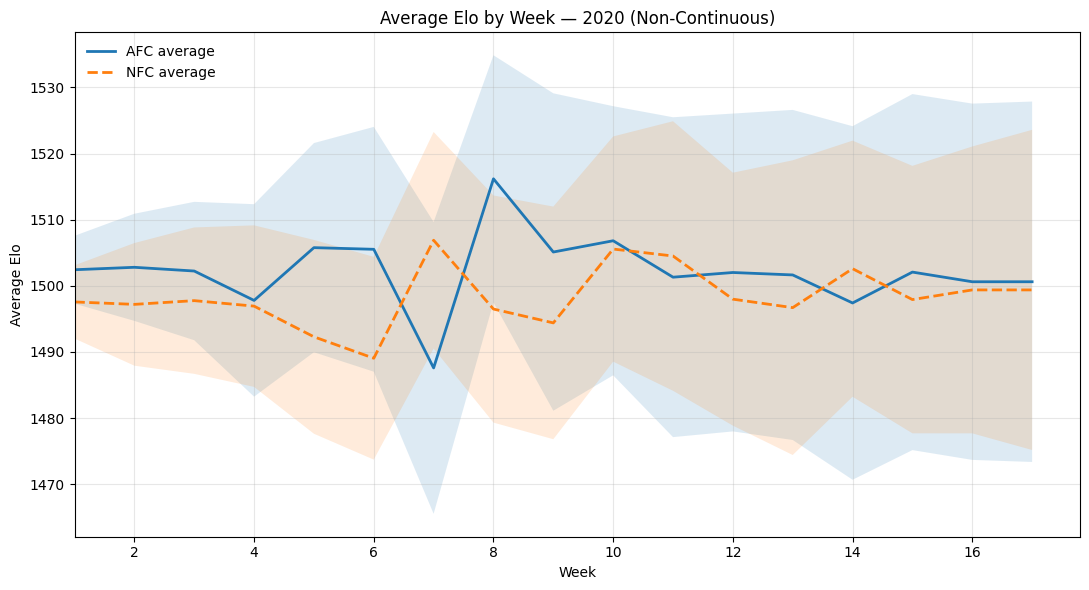

In [ ]:
season_year = 2020

df = elo_nc.copy()

# home and away into a single team-week time series
home = df[["season","week_num","home_team_label","post_elo_home"]].rename(
    columns={"home_team_label":"team_label","post_elo_home":"elo"}
)
away = df[["season","week_num","away_team_label","post_elo_away"]].rename(
    columns={"away_team_label":"team_label","post_elo_away":"elo"}
)

long = pd.concat([home, away], ignore_index=True)

# clean and keep the season
long["week_num"] = pd.to_numeric(long["week_num"], errors="coerce")
long = long[(long["season"] == season_year) &
            long["week_num"].notna() &
            long["elo"].notna()].copy()

# extract conferences from "Team-AFC-E"/"Team-NFC-W"
parts = long["team_label"].str.split("-", n=2, expand=True)
long["conf"] = parts[1]   # AFC / NFC

# if the team appears twice in the same week, average
team_week = (long
             .groupby(["season","conf","team_label","week_num"], as_index=False)
             .agg(elo=("elo","mean")))

# conference average per week (+ std and SEM)
agg = (team_week
       .groupby(["season","conf","week_num"], as_index=False)
       .agg(avg_elo=("elo","mean"),
            std_elo=("elo","std"),
            n_teams=("team_label","nunique")))
agg["sem_elo"] = agg["std_elo"] / agg["n_teams"].clip(lower=1).pow(0.5)

# Pivot to plot easily
plot_df = agg.pivot_table(index="week_num", columns="conf", values="avg_elo")

# Optional: SEM bands per conference
sem = {c: agg[agg["conf"] == c].set_index("week_num")["sem_elo"]
       for c in ["AFC", "NFC"]}

plt.figure(figsize=(11,6))
for conf, style in zip(["AFC","NFC"], ["-", "--"]):
    if conf in plot_df.columns:
        y = plot_df[conf].sort_index()
        plt.plot(y.index, y.values, linestyle=style, linewidth=2, label=f"{conf} average")
        if conf in sem and len(sem[conf]) > 0:
            s = sem[conf].reindex(y.index).fillna(0.0).values
            plt.fill_between(y.index, y.values - s, y.values + s, alpha=0.15)

plt.title(f"Average Elo by Week — {season_year} (Non-Continuous)")
plt.xlabel("Week")
plt.ylabel("Average Elo")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", frameon=False)
plt.xlim(left=1)
plt.tight_layout()
plt.show()


Elo Delta vs Mode of Victory

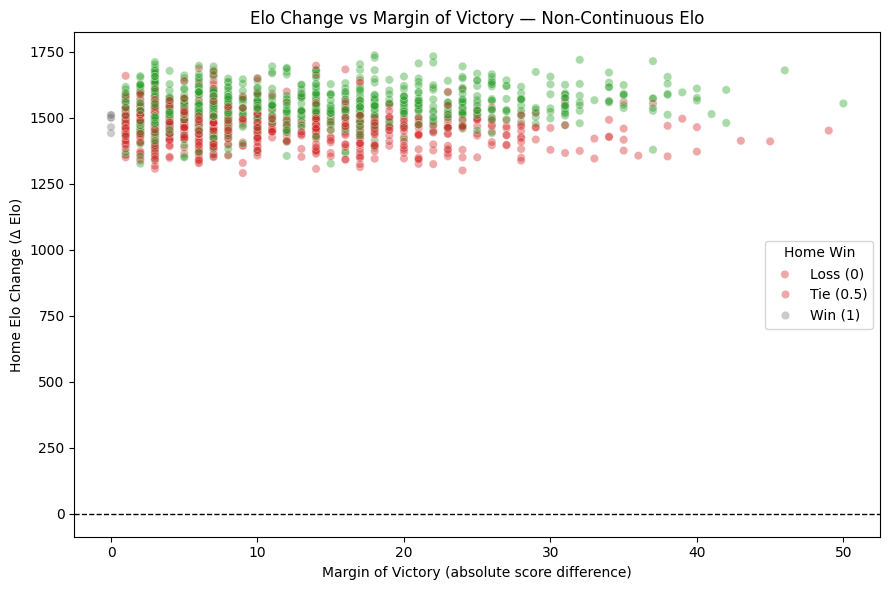

In [ ]:
df = elo_nc.copy()

#Get Delta and MOV
df = df[df["margin_of_victory"].notna() & df["elo_delta_home"].notna()].copy()

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=df,
    x="margin_of_victory",
    y="elo_delta_home",
    hue="home_win",
    palette={1:"tab:green",0:"tab:red",0.5:"tab:gray"},
    alpha=0.4
)
plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Margin of Victory (absolute score difference)")
plt.ylabel("Home Elo Change (Δ Elo)")
plt.title("Elo Change vs Margin of Victory — Non-Continuous Elo")
plt.legend(title="Home Win", labels=["Loss (0)", "Tie (0.5)", "Win (1)"])
plt.tight_layout()
plt.show()

/tmp/ipython-input-1864876386.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("mov_bin")["elo_delta_home"]


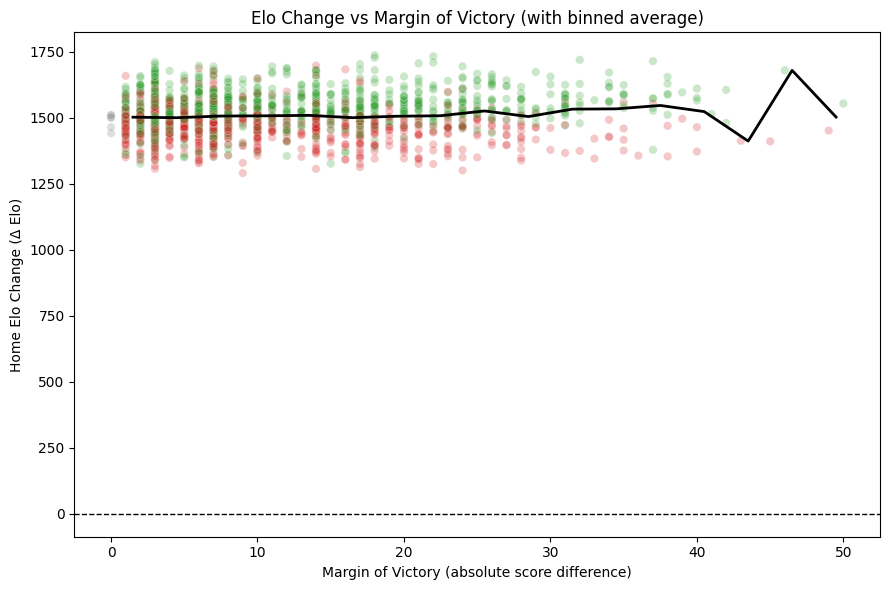

In [ ]:
# Bin MOV in 3-point buckets
bins = np.arange(0, df["margin_of_victory"].max() + 3, 3)
df["mov_bin"] = pd.cut(df["margin_of_victory"], bins)

bin_means = (
    df.groupby("mov_bin")["elo_delta_home"]
      .mean()
      .reset_index()
      .dropna()
)

# Get bin centers for x-axis
bin_centers = bin_means["mov_bin"].apply(lambda x: x.mid)

plt.figure(figsize=(9,6))
sns.scatterplot(
    data=df,
    x="margin_of_victory",
    y="elo_delta_home",
    hue="home_win",
    palette={1: "tab:green", 0: "tab:red", 0.5: "tab:gray"},
    alpha=0.25,
    legend=False
)
plt.plot(bin_centers, bin_means["elo_delta_home"], color="black", linewidth=2)

plt.axhline(0, color="black", linewidth=1, linestyle="--")
plt.xlabel("Margin of Victory (absolute score difference)")
plt.ylabel("Home Elo Change (Δ Elo)")
plt.title("Elo Change vs Margin of Victory (with binned average)")
plt.tight_layout()
plt.show()


# Continues ELO Model

In [ ]:
OUT_PATH = f"{DATA_NFL_DIR}/games_elo_continuous.csv"

#load and basic check
df = pd.read_csv(In_PATH)

df = df.sort_values(["season", "week_num", "Date", "home_team", "away_team"])

#Elo loop (continous)
ratings = {}        #carries accross seasons
rows = []

for idx, g in df.iterrows():
  home = g["home_team"]
  away = g["away_team"]
  season = g[["season"]]

  #Get the intial rating
  r_home = ratings.get(home, INTITIAL_ELO)
  r_away = ratings.get(away, INTITIAL_ELO)

  #Compute expected win probability
  hfa = g["home_field_advantage_pts"]
  e_home = expected_home_win(r_home, r_away, hfa)

  #Actual elo
  s_home = g["home_win"]
  mov_mult = g["mov_multiplier"]

  #Apply Elo update
  post_home, post_away, delta = Update_ratings(r_home, r_away, s_home, e_home, mov_mult, K_FACTOR )

  #Save back
  ratings[home] = post_home
  ratings[away] = post_away

  #record for output
  row = dict(g)
  row.update({
      "pre_elo_home": r_home,
      "pre_elo_away": r_away,
      "elo_E_home": e_home,
      "elo_delta_home": delta,
      "post_elo_home": post_home,
      "post_elo_away": post_away,

  })
  rows.append(row)

elo_cont = pd.DataFrame(rows)

#save
elo_cont.to_csv(OUT_PATH, index=False)
print(f"Saved to {OUT_PATH}")


# Check for duplicate
keys = ["season", "week_num", "Date", "home_team", "away_team"]

dupes = elo_cont[elo_cont.duplicated(keys, keep=False)].sort_values(keys)
print("Number of duplicated game keys:", dupes.shape[0])

#  Inspect first few rows
print(elo_cont.head(15)[[
    "season", "week_num", "Date",
    "home_team", "away_team",
    "home_field_advantage_pts",
    "pre_elo_home", "pre_elo_away",
    "elo_E_home", "elo_delta_home",
    "post_elo_home", "post_elo_away"
]])

#  Average Elo
print("Average Elo (should stay near ~1500):")
print(elo_cont[["pre_elo_home", "pre_elo_away", "post_elo_home", "post_elo_away"]].mean())


Saved to /content/drive/MyDrive/NFL_Project/reports/games_elo_continuous.csv
Number of duplicated game keys: 0
    season  week_num        Date             home_team              away_team  \
0     2019       1.0  2019-09-05         Chicago Bears      Green Bay Packers   
1     2019       1.0  2019-09-08     Arizona Cardinals          Detroit Lions   
2     2019       1.0  2019-09-08     Carolina Panthers       Los Angeles Rams   
3     2019       1.0  2019-09-08      Cleveland Browns       Tennessee Titans   
4     2019       1.0  2019-09-08        Dallas Cowboys        New York Giants   
5     2019       1.0  2019-09-08  Jacksonville Jaguars     Kansas City Chiefs   
6     2019       1.0  2019-09-08  Los Angeles Chargers     Indianapolis Colts   
7     2019       1.0  2019-09-08        Miami Dolphins       Baltimore Ravens   
8     2019       1.0  2019-09-08     Minnesota Vikings        Atlanta Falcons   
9     2019       1.0  2019-09-08  New England Patriots    Pittsburgh Steelers  

#VISUAL

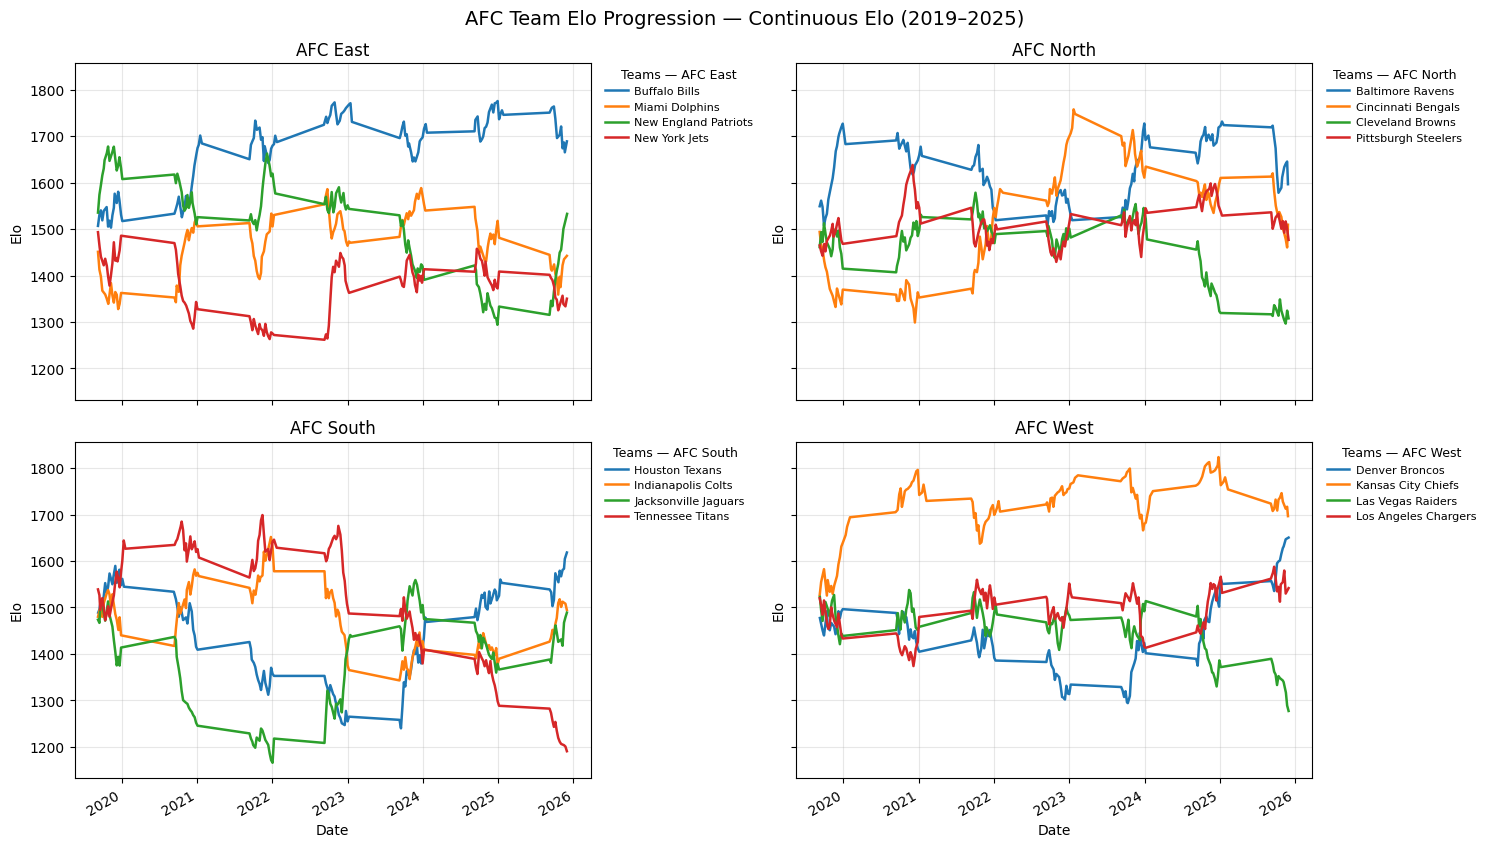

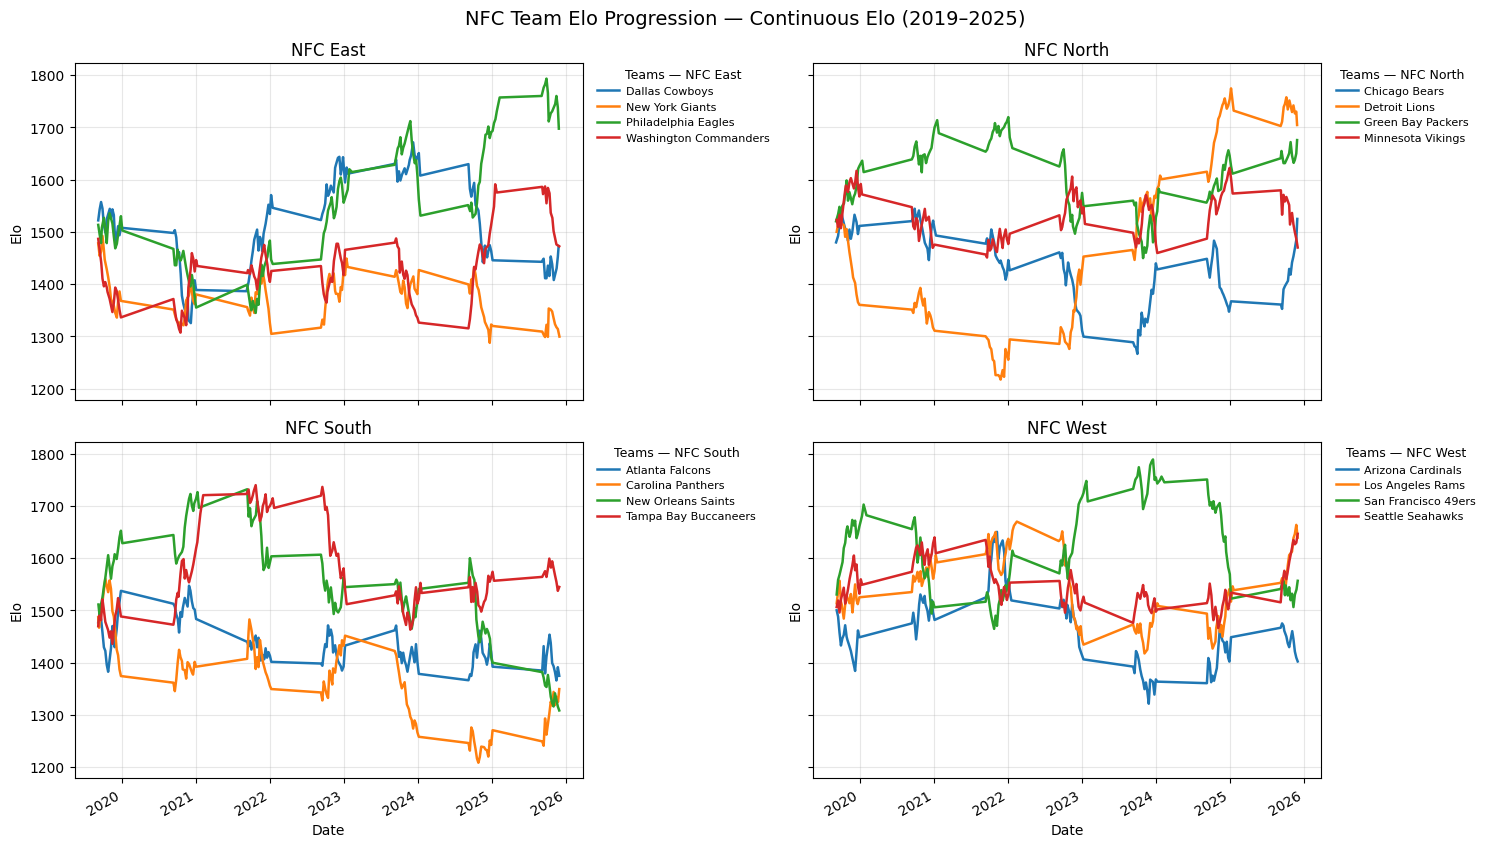

In [ ]:
elo_cont = pd.read_csv(f"{DATA_NFL_DIR}/games_elo_continuous.csv")

# Team metadata
teams_meta = pd.read_csv(f"{DATA_NFL_DIR}/nfl_teams_conferences.csv")
teams_meta["suffix"] = teams_meta["conference"] + "-" + teams_meta["division"].str[0]
lookup = dict(zip(teams_meta["team"], teams_meta["suffix"]))

# Attach labels
elo_cont["home_team_full"] = elo_cont["home_team"].map(lookup).fillna("")
elo_cont["away_team_full"] = elo_cont["away_team"].map(lookup).fillna("")
elo_cont["home_team_label"] = elo_cont["home_team"] + "-" + elo_cont["home_team_full"]
elo_cont["away_team_label"] = elo_cont["away_team"] + "-" + elo_cont["away_team_full"]

# Make sure Date is datetime
elo_cont["Date"] = pd.to_datetime(elo_cont["Date"])

df = elo_cont.copy()

# Combine home + away Elo into one long table
home = df[["season", "Date", "home_team_label", "post_elo_home"]].rename(
    columns={"home_team_label": "team_label", "post_elo_home": "elo"}
)
away = df[["season", "Date", "away_team_label", "post_elo_away"]].rename(
    columns={"away_team_label": "team_label", "post_elo_away": "elo"}
)

long = pd.concat([home, away], ignore_index=True)

# Drop rows without Elo/Date
long = long[long["elo"].notna() & long["Date"].notna()].copy()

# Extract conference & division from "Team-Conf-D"
parts = long["team_label"].str.split("-", n=2, expand=True)
long["conf"] = parts[1]            # AFC / NFC
long["div"]  = parts[2]            # E / N / S / W

# If a team somehow has multiple rows with same Date (very rare), average
long = (long
        .groupby(["team_label", "conf", "div", "Date"], as_index=False)
        .agg(elo=("elo", "mean")))

def plot_conference_divisions_continuous(long_df, conference,
                                         start_year=None, end_year=None):
    """
    Multi-year team Elo trajectories for continuous Elo,
    arranged in 4 subplots (East, North, South, West).
    Allows year filtering.
    """
    div_order = ["E", "N", "S", "W"]
    div_full  = {"E": "East", "N": "North", "S": "South", "W": "West"}

    df = long_df.copy()

    # ----- Apply year filtering -----
    if start_year is not None:
        df = df[df["Date"].dt.year >= start_year]

    if end_year is not None:
        df = df[df["Date"].dt.year <= end_year]

    # Create 2x2 grid, enlarged by 8%
    fig, axes = plt.subplots(2, 2, figsize=(15, 8.6), sharex=True, sharey=True)
    axes = axes.ravel()

    # reserve room for legends
    plt.subplots_adjust(right=0.82)

    # Filter by conference
    conf_df = df[df["conf"] == conference].copy()

    for ax, d in zip(axes, div_order):
        sub = conf_df[conf_df["div"] == d]

        ax.set_title(f"{conference} {div_full[d]}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Elo")
        ax.grid(True, alpha=0.3)

        for team, tdf in sub.groupby("team_label"):
            tdf = tdf.sort_values("Date")
            team_name = team.split("-")[0]
            ax.plot(tdf["Date"], tdf["elo"], linewidth=1.8, label=team_name)

        # Outside legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles, labels,
            title=f"Teams — {conference} {div_full[d]}",
            loc="upper left", bbox_to_anchor=(1.02, 1.0),
            borderaxespad=0.0, frameon=False,
            fontsize=8, title_fontsize=9,
            ncol=1, handlelength=2, handletextpad=0.6,
        )

    # Title
    date_range_str = ""
    if start_year or end_year:
        date_range_str = f" ({start_year if start_year else ''}–{end_year if end_year else ''})"

    fig.suptitle(
        f"{conference} Team Elo Progression — Continuous Elo{date_range_str}",
        y=0.98,
        fontsize=14
    )

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


plot_conference_divisions_continuous(long, "AFC", start_year=2019, end_year=2025)
plot_conference_divisions_continuous(long, "NFC", start_year=2019, end_year=2025)
